In [1]:
# This is needed so that python finds the utils
import sys
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code")

# Needed for compression as the common source of randomness
from sobol_seq import i4_sobol_generate
import numpy as np
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



$$
\newcommand{\N}{\mathbb{N}}
\newcommand{\X}{\mathcal{X}}
$$
The algorithm is as follows [1]:

**Rej-Sampler**$(P, Q)$
Random Input: $\langle x_i \mid i \in \N \rangle$ a sequence of i.i.d. samples from $Q$.

 1. Initialisation 
 
    1. For each $x \in \X$, set $p_0(x) \leftarrow 0$.
    2. Set $p^*_0 \leftarrow 0$.
    
 2. **For** $i \leftarrow 1$ to $\infty$ **do**
 
    1. Set $\alpha_i(x) \leftarrow \min\{P(x) - p_{i-1}(x), (1 - p^*_{i-1})Q(x) \} \quad \forall x \in \X$.
    2. Set $p_i(x) \leftarrow p_{i - 1}(x) + \alpha_i(x) \quad \forall x \in \X$.
    3. Set $p_i^* \leftarrow \sum_{x \in \X} p_i(x)$
    4. Set $\beta_i(x_i) \leftarrow \frac{\alpha_i(x)}{(1 - p^*_{i-1})Q(x)}$
    5. Sample $u \leftarrow \mathrm{Uniform}(0, 1)$
    6. **If** $u < \beta_i(x_i)$ **then**
    
        **return** $i, x_i$

In [2]:
def rejection_sampler(P, Q, seed, failure_threshold=1000):
    """
    P, Q - lists of positive reals that sum to one
    """
    
    np.random.seed(seed)
    
    n = len(P)
    
    # Initialisation
    alpha = [0] * n
    p = [0] * n
    p_star = 0
    
    # Rejection sampling loop
    for i in range(failure_threshold):
        
        p_star_ = 0
        
        # Step 2.A and 2.B
        for x in range(n):
            alpha[x] = np.minimum(P[x] - p[x], (1 - p_star) * Q[x])
            p[x] = p[x] + alpha[x]
            p_star_ += p[x]
            
        
        # Step 2.D and Step 2.C - we exchange these so that we don't need to keep
        # both p_star_i and p_star_{i - 1} around
        x_i = np.random.choice(n, None, p=Q)
        beta_i = alpha[x_i] / ((1 - p_star) * Q[x_i])
        
        p_star = p_star_
        
        # Step 2.E
        u = np.random.uniform()
        
        # Step 2.F
        if u < beta_i:
            return i, x_i
        
    return None

def kl_divergence(P, Q):
    return np.sum(P * (np.log(P) - np.log(Q)))
        

In [3]:
np.random.seed(42)

P = np.random.uniform(size=40)
P = P / np.sum(P)

Q = np.ones(len(P)) / len(P)

samples = []
mass = np.zeros(len(P))

for j in tqdm(range(50, 5050)):
    sample = rejection_sampler(P=P, Q=Q, seed=j, failure_threshold=1000)
    samples.append(sample)
    
    i, x_i = sample
    
    mass[x_i] += 1
    
mass = mass / np.sum(mass)

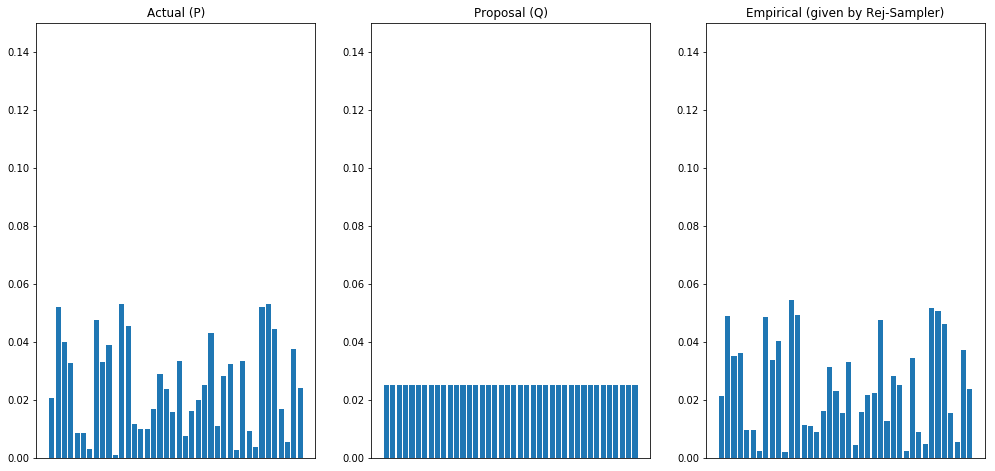

KL divergence between P and Q: 0.225


In [4]:
plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.bar(np.arange(len(P)), P)
plt.ylim([0, 0.15])
plt.xticks([])
plt.title("Actual (P)")

plt.subplot(132)
plt.bar(np.arange(len(P)), Q)
plt.ylim([0, 0.15])
plt.xticks([])
plt.title("Proposal (Q)")

plt.subplot(133)
plt.bar(np.arange(len(P)), mass)
plt.ylim([0, 0.15])
plt.xticks([])
plt.title("Empirical (given by Rej-Sampler)")

plt.show()

print("KL divergence between P and Q: {:.3f}".format(kl_divergence(P, Q)))

1.0


1.2201752366211964

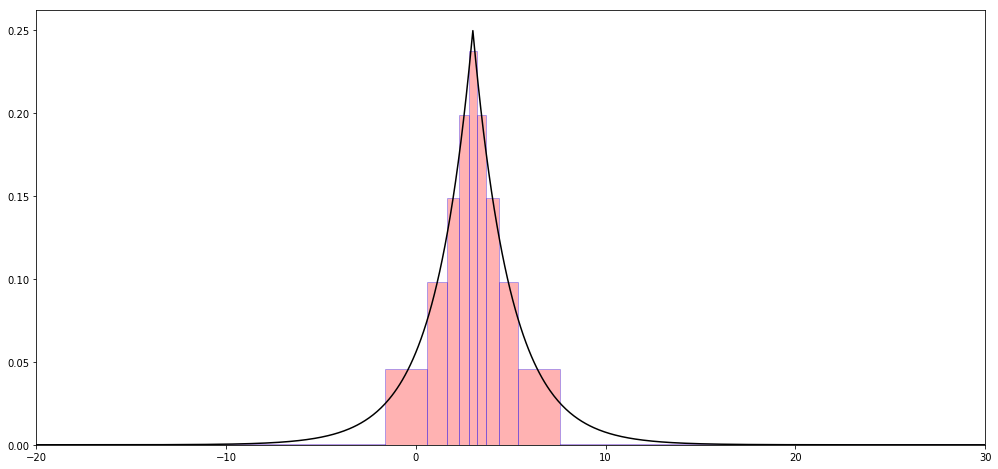

In [5]:
delta = 10e-2
b = 2
mu = 3

def laplace_pdf(x, mu, b): 
    return 1. / (2 * b) * np.exp(-np.abs(x - mu) / b)

def laplace_cdf(x, mu, b):
    ind = (x > mu).astype(np.float32)
    
    return (1 - ind) * (0.5 * np.exp(-(mu - x) / b)) + ind * (1 - 0.5 * np.exp(-(x - mu) / b))

def laplace_quantile(p, loc, scale):
    
    return loc - scale * np.sign(p - 0.5) * np.log(1 - 2 * np.abs(p - 0.5))
    
def pos_bin_edge(a, delta, mu, b):    
    return mu - b * np.log(1 - 2 * a * delta)

def neg_bin_edge(a, delta, mu, b):    
    return mu + b * np.log(1 - 2 * a * delta)
    
num_bins = (np.floor(1 / delta) + 1) // 2

pos_bin_edges = pos_bin_edge(np.arange(num_bins) + 0.5, delta, mu, b)
neg_bin_edges = neg_bin_edge(np.arange(num_bins) + 0.5, delta, mu, b)

bin_edges = np.concatenate((neg_bin_edges[::-1], pos_bin_edges))

widths = bin_edges[1:] - bin_edges[:-1]
widths = np.concatenate((100 * np.ones((1,)), widths, 100 * np.ones((1,))))

bin_edges = np.concatenate((bin_edges[:1] - 100, bin_edges))

heights = delta / widths

heights[0] /= 2
heights[-1] /= 2

xs = np.linspace(-30, 40, 1000)

plt.figure(figsize=(17,8))
plt.plot(xs,
         laplace_pdf(xs, mu, b),
         color='k')

plt.bar(x=bin_edges, 
        height=heights,
        width=widths,
        align="edge",
        alpha=0.3,
        color='r',
        edgecolor='b')

plt.xlim([-20, 30])

print(np.sum(widths*heights))

np.sum(heights)

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



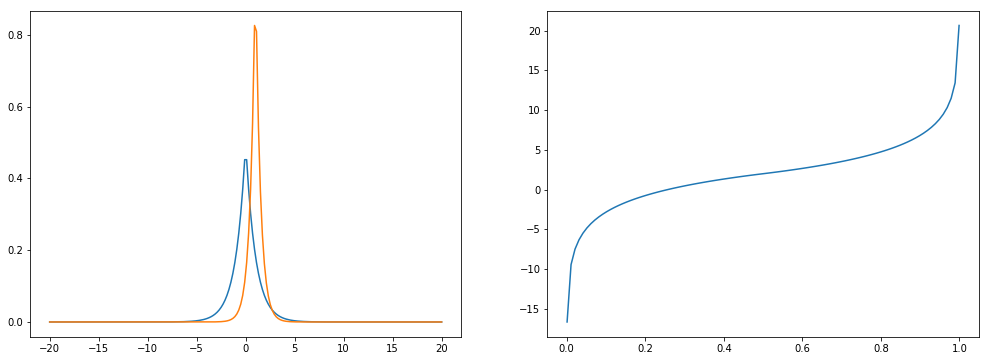

In [28]:
prior = tfd.Laplace(loc=0., scale=1.)
posterior = tfd.Laplace(loc=1., scale=0.5)

tf.random.set_random_seed(42)

xs = np.linspace(-20, 20, 200)
ys = np.linspace(0.001, 0.999, 100)

plt.figure(figsize=(17, 6))

plt.subplot(121)
plt.plot(xs, prior.prob(xs))
plt.plot(xs, posterior.prob(xs))

plt.subplot(122)
plt.plot(ys, laplace_quantile(ys, 2., 3.))

plt.show()

In [29]:
def create_bins_and_masses(dist, quantile_fn, delta, tail_length=100.):
    num_edges = int(np.floor(1. / delta) + 1)

    percentages = np.arange(0., 1., delta) + delta / 2
    
    edges = quantile_fn(percentages, loc=dist.loc, scale=dist.scale)
    
    widths = tail_length * np.ones((num_edges,))
    widths[1:-1] = edges[1:] - edges[:-1]
    
    mass = delta / widths
    
    mass /= np.sum(mass)
    
    return edges, mass

def get_prior_mass_correspondance(posterior_bins, prior):
    
    prior_mass = np.zeros((len(posterior_bins) + 1,))
    
    prior_mass[0] = prior.cdf(posterior_bins[0])
    prior_mass[1:-1] = prior.cdf(posterior_bins[1:]) - prior.cdf(posterior_bins[:-1])
    prior_mass[-1] = 1 - np.sum(prior_mass)
    
    return prior_mass
    
def get_bin(x, bins):
    
    for idx, b in enumerate(bins):
        if x < b: return idx
    else:
        idx = len(bins)
        
    return idx

In [30]:
def rejection_sampler_cts(P, P_bins, Q, Q_dist, seed, failure_threshold=1000):
    """
    """
    
    np.random.seed(seed)
    tf.random.set_random_seed(seed)
    
    n = len(P)
    
    # Initialisation
    alpha = [0] * n
    p = [0] * n
    p_star = 0
    
    # Rejection sampling loop
    for i in range(failure_threshold):
        
        p_star_ = 0
        
        # Step 2.A and 2.B
        for x in range(n):
            alpha[x] = np.minimum(P[x] - p[x], (1 - p_star) * Q[x])
            p[x] = p[x] + alpha[x]
            p_star_ += p[x]
        
        # Step 2.D and Step 2.C - we exchange these so that we don't need to keep
        # both p_star_i and p_star_{i - 1} around
        # Note: the differences compared to the finite case is that
        # we use Q's custom sampler and we get the corresponding bin of the sample
        # in the quantized distribution
        x_i = Q_dist.sample()
        x_i_P_bin = get_bin(x_i, P_bins)
        
        beta_i = alpha[x_i_P_bin] / ((1 - p_star) * Q[x_i_P_bin])
        
        p_star = p_star_
        
        # Step 2.E
        u = np.random.uniform()
        
        # Step 2.F
        if u < beta_i:
            return i, x_i, x_i_P_bin
        
    return None

Min: 0 
First Quartile: 0.0
Median: 2.0
Third Quartile: 8.0
Max:196
Outliers below first quartile: 0
Outliers above third quartile: 1191


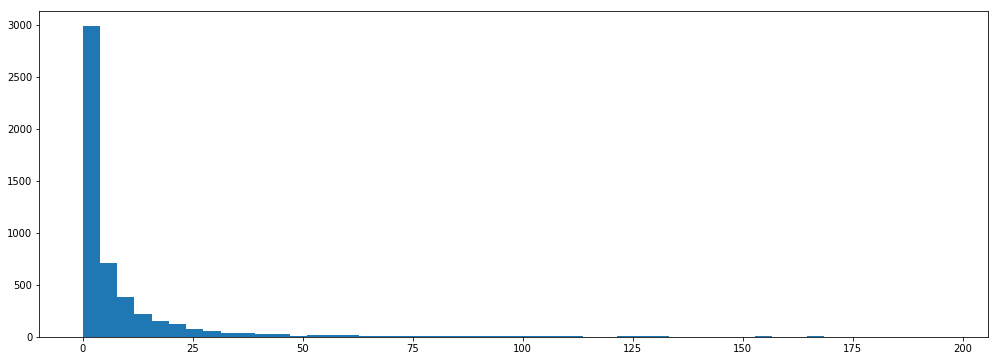

In [34]:
prior = tfd.Laplace(loc=0., scale=1.)
posterior = tfd.Laplace(loc=1., scale=0.5)

P_bin, P = create_bins_and_masses(posterior, laplace_quantile, 1e-2)
Q = get_prior_mass_correspondance(P_bin, prior)

samples = []
mass = np.zeros(len(P))

num_samples = 5000

seed = 50
for j in tqdm(range(num_samples)):
    
    sample = None
    
    while sample is None:
        sample = rejection_sampler_cts(P, P_bin, Q, prior, seed=seed, failure_threshold=200)
        seed += 1
        
    samples.append(sample)
    
    i, x_i, bin_idx = sample
    
    mass[bin_idx] += 1
    
mass = mass / np.sum(mass)

indices, samps, bin_indices = zip(*samples)
indices = np.array(indices)

quarters = np.percentile(indices, [25, 50, 75])
min_idx, max_idx = np.min(indices), np.max(indices)

print("Min: {} \nFirst Quartile: {}\nMedian: {}\nThird Quartile: {}\nMax:{}".format(min_idx, 
                                                                                    quarters[0], 
                                                                                    quarters[1], 
                                                                                    quarters[2], 
                                                                                    max_idx))

print("Outliers below first quartile: {}\nOutliers above third quartile: {}".format(np.sum(indices < quarters[0]),
                                                                                    np.sum(indices > quarters[2])))
plt.figure(figsize=(17, 6))
plt.hist(indices, bins=50)
plt.show()

1.0

5000 of 5000 samples accepted
Min: 0 
First Quartile: 0.0
Median: 1.0
Third Quartile: 4.0
Max:163
Outliers below first quartile: 0
Outliers above third quartile: 1152


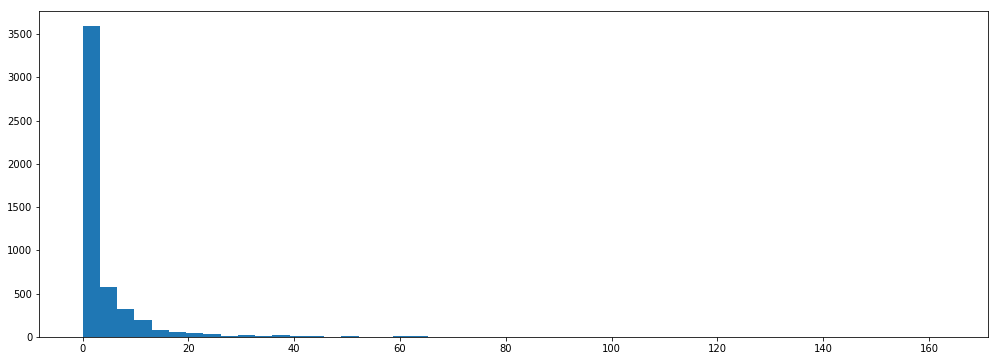

In [37]:
prior = tfd.Normal(loc=0., scale=1.)
posterior = tfd.Normal(loc=1., scale=.5)

P_bin, P = create_bins_and_masses(posterior, norm.ppf, 1e-2)
Q = get_prior_mass_correspondance(P_bin, prior)

samples_ = []
mass = np.zeros(len(P))

num_samples = 5000

seed = 50
for j in tqdm(range(num_samples)):
    
    sample = None
    
    while sample is None:
        sample = rejection_sampler_cts(P, P_bin, Q, prior, seed=seed, failure_threshold=200)
        seed += 1
        
    samples_.append(sample)
    
    i, x_i, bin_idx = sample
    
    mass[bin_idx] += 1
    
mass = mass / np.sum(mass)

print("{} of {} samples accepted".format(len(samples_), num_samples))

indices, samps_, bin_indices = zip(*samples_)
indices = np.array(indices)

quarters = np.percentile(indices, [25, 50, 75])
min_idx, max_idx = np.min(indices), np.max(indices)

print("Min: {} \nFirst Quartile: {}\nMedian: {}\nThird Quartile: {}\nMax:{}".format(min_idx, 
                                                                                    quarters[0], 
                                                                                    quarters[1], 
                                                                                    quarters[2], 
                                                                                    max_idx))

print("Outliers below first quartile: {}\nOutliers above third quartile: {}".format(np.sum(indices < quarters[0]),
                                                                                    np.sum(indices > quarters[2])))
plt.figure(figsize=(17, 6))
plt.hist(indices, bins=50)
plt.show()

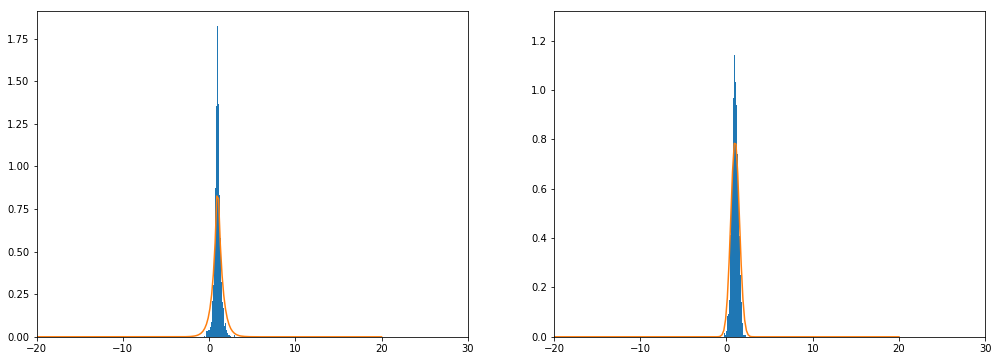

In [38]:
posterior1 = tfd.Laplace(loc=1., scale=.5)
posterior2 = tfd.Normal(loc=1., scale=.5)

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.hist(samps, bins=100, density=True)
plt.plot(xs, posterior1.prob(xs))
plt.xlim([-20, 30])

plt.subplot(122)
plt.hist(samps_, bins=100, density=True)
plt.plot(xs, posterior2.prob(xs))
plt.xlim([-20, 30])
plt.show()

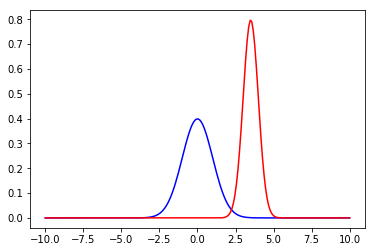

In [6]:
p_loc = 0.
p_scale = 1.
p = tfd.Normal(loc=p_loc, scale=p_scale)

q_loc = 3.5
q_scale = 0.5
q = tfd.Normal(loc=q_loc, scale=q_scale)

plot_points = np.linspace(-10., 10., 200)

plt.plot(plot_points, p.prob(plot_points), 'b')
plt.plot(plot_points, q.prob(plot_points), 'r')
plt.show()

$$
\newcommand{\N}{\mathbb{N}}
\newcommand{\X}{\mathcal{X}}
$$
The algorithm is as follows [1]:

**Rej-Sampler**$(P, Q)$
Random Input: $\langle x_i \mid i \in \N \rangle$ a sequence of i.i.d. samples from $Q$.

 1. Initialisation 
 
    1. For each $x \in \X$, set $p_0(x) \leftarrow 0$.
    2. Set $p^*_0 \leftarrow 0$.
    
 2. **For** $i \leftarrow 1$ to $\infty$ **do**
 
    1. Set $\alpha_i(x) \leftarrow \min\{P(x) - p_{i-1}(x), (1 - p^*_{i-1})Q(x) \} \quad \forall x \in \X$.
    2. Set $p_i(x) \leftarrow p_{i - 1}(x) + \alpha_i(x) \quad \forall x \in \X$.
    3. Set $p_i^* \leftarrow \sum_{x \in \X} p_i(x)$
    4. Set $\beta_i(x_i) \leftarrow \frac{\alpha_i(x)}{(1 - p^*_{i-1})Q(x)}$
    5. Sample $u \leftarrow \mathrm{Uniform}(0, 1)$
    6. **If** $u < \beta_i(x_i)$ **then**
    
        **return** $i, x_i$

In [7]:
tf.random.set_random_seed(42)

p_loc = 0.
p_scale = 1.
p = tfd.Normal(loc=p_loc, scale=p_scale)

q_loc = 0.5
q_scale = 0.5
q = tfd.Normal(loc=q_loc, scale=q_scale)

n_points = 20

p_mass = tf.concat(([0.], [1. / (n_points - 2)] * (n_points - 2), [0.]), axis=0)
quantiles = np.linspace(0., 1., n_points + 1)
open_sections = q.quantile(quantiles[1:-1])

open_cdf = p.cdf(open_sections)
cdfs = tf.concat(([0.], open_cdf, [1.]), axis=0)
probs = cdfs[1:] - cdfs[:-1]

infinities = np.inf * tf.ones(n_points - 1)
indices = tf.convert_to_tensor(np.arange(n_points - 1, dtype=np.float32))

rejection_samples = []
for i in tqdm(range(10)):
    
    p_i = tf.zeros((n_points))
    
    accepted = False
    j = 0
    
    while not accepted:
        p_star = tf.reduce_sum(p_i)
        alpha_i = tf.where(p_mass - p_i < (1 - p_star) * probs, p_mass - p_i, (1 - p_star) * probs)
        
        sample = p.sample()
        
        #bucket = tf.concat((tf.reshape(tf.where(sample < open_sections),[-1]), [n_points-1]), axis=0)[0]
        bucket = tf.concat((tf.where(sample < open_sections, indices, infinities), [n_points - 1]), axis=0)
        bucket = tf.argmin(bucket)
        beta = (alpha_i[bucket]) / ((1 - p_star) * probs[bucket])
        accepted = (tf.random.uniform(()) < beta)

        p_i = p_i + alpha_i
        
        j += 1
        
    #print(j)
    rejection_samples.append(sample)
#rejection_samples

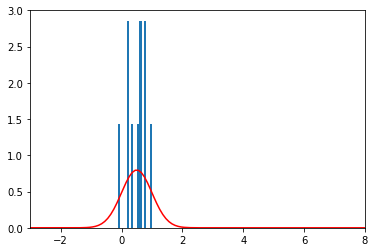

In [8]:
plt.hist(rejection_samples, range=(-2, 5), normed=True, bins=100)
plt.plot(plot_points, q.prob(plot_points), 'r')
plt.xlim([-3, 8])
plt.show()

In [90]:
def rejection_sample(p_loc,
                     p_scale,
                     q_loc,
                     q_scale,
                     num_latents,
                     num_samples,
                     show_plot,
                     num_draws,
                     seed,
                     n_points=20):

    
    tf.random.set_random_seed(seed)
    
    # Instantiate the proposal distribution p and target q
    p = tfd.Normal(loc=p_loc * tf.ones(num_latents), scale=p_scale * tf.ones(num_latents))
    q = tfd.Normal(loc=q_loc * tf.ones(num_latents), scale=q_scale * tf.ones(num_latents))
    
    # Set up bins for a single distribution
    p_mass = tf.concat(([0.], [1. / (n_points - 2)] * (n_points - 2), [0.]), axis=0)
    quantiles = np.linspace(0., 1., n_points + 1)
    
    # Set up bins for each latent by repeating it
    # Note: sample space is first index, number of latents is second
    p_mass = np.repeat(p_mass[None, :], num_latents, axis=0).T
    quantiles = np.repeat(quantiles[None, :], num_latents, axis=0)
    
    # Density of Q at edges of the bins
    open_sections = q.quantile(quantiles[:, 1:-1].T)
    
    open_cdf = p.cdf(open_sections)
    cdfs = tf.concat((tf.zeros((1, num_latents)), open_cdf, tf.ones((1, num_latents))), axis=0)
    probs = cdfs[1:, :] - cdfs[:-1, :]
    
    # Need these for the parallelisation
    latent_indices = tf.convert_to_tensor(np.arange(num_latents))
    
    indices_ = np.repeat(np.arange(n_points, dtype=np.float32)[None, :], num_latents, axis=0).T
    indices_ = tf.convert_to_tensor(indices_)
    indices = indices_[:-1, :]
    
    last_indices = indices_[-1:, :]
    
    infinities = np.inf * tf.ones_like(indices)
    
    # --------------------------------------------------------------
    # Perform Rejection Sampling
    # --------------------------------------------------------------

    # Initialise p_i for each latent
    p_i = tf.zeros((n_points, num_latents))
    
    # Accepted is now a mask
    accepted = tf.zeros((num_latents,), dtype=tf.bool)
    
    # Initialise all samples to infinity (as an invalid value)
    sample = np.inf * tf.ones((num_latents))
    sample_indices = np.inf * tf.ones((num_latents))

    for j in tqdm(range(num_draws)):
        
        # Sum along the sample space dimension
        # to get total probability mass for each dim
        p_star = tf.reduce_sum(p_i, axis=0)
#         print(p_star)
        
        # Calculate the alpha_is
        a = p_mass - p_i
        b = (1 - p_star) * probs
        
#         print(a)
#         print(b)

        alpha_i = tf.where(a < b, a, b)
        
#         print(alpha_i)
#         print("----")
        
        # Draw a sample from the proposal distribution
        new_sample = p.sample()

        # Find which bucket the sample falls into
        bucket_index_matrix = tf.concat([tf.where(new_sample < open_sections, indices, infinities), last_indices],
                                        axis=0)

        buckets = tf.argmin(bucket_index_matrix, axis=0)
        buckets = tf.transpose(tf.stack((buckets, latent_indices)))

        # Get the appropriate alphas and Qs
        alphas_i = tf.gather_nd(alpha_i, buckets)
        probs_i = tf.gather_nd(probs, buckets)

        # Calculate the betas
        betas = alphas_i / ((1 - p_star) * probs_i)

        accept_samples = tf.random.uniform((num_latents,))
        
        # Get new accept flags
        new_accepted = accept_samples < betas
        
        # Update the sample and index matrices which don't have their values set yet
        # and are accepted in the current round
        update_indices = tf.logical_and(new_accepted, tf.logical_not(accepted))
        
        sample = tf.where(update_indices, new_sample, sample)
        sample_indices = tf.where(update_indices, j * tf.ones_like(sample_indices), sample_indices)
        #print(sample)
        
        accepted = tf.math.logical_or(new_accepted, accepted)
        #print(accepted)
        
        p_i = p_i + alpha_i

    if show_plot:
        plt.hist(rejection_samples, range=(-3., 8.), normed=True, bins=100)
        plt.plot(plot_points, q.prob(plot_points), 'r')
        plt.show()

    return sample, sample_indices, accepted

In [103]:
def decode_rejection_sample(p_loc, p_scale, seed, index_matrix, num_latents=10000):
    tf.random.set_random_seed(seed)
    
    # Instantiate the proposal distribution p and target q
    p = tfd.Normal(loc=p_loc * tf.ones(num_latents), scale=p_scale * tf.ones(num_latents))
    
    # Initialise all samples to infinity (as an invalid value)
    sample = np.inf * tf.ones((num_latents))
    
    for j in tqdm(range(tf.reduce_max(index_matrix[index_matrix != np.inf]) + 1)):
        
        new_sample = p.sample()
        
        # Set the appropriate samples
        sample = tf.where(index_matrix == j, new_sample, sample)
        
        # We have to do this so that the decoder's prior samples' 
        # random generator state is in sync with the encoder
        tf.random.uniform((num_latents,))
        
    return sample

In [104]:
seed = 42

samps, sample_indices, accepted = rejection_sample(p_loc=0.,
                                                   p_scale=1.,
                                                   q_loc=-1.,
                                                   q_scale=0.4,
                                                   num_samples=1,
                                                   num_latents=10000,
                                                   n_points=30,
                                                   num_draws=256,
                                                   seed=seed,
                                                   show_plot=False)

In [105]:
decoded_sample = decode_rejection_sample(p_loc=0.,
                                         p_scale=1.,
                                         seed=42,
                                         index_matrix=sample_indices.numpy(),
                                         num_latents=10000)

In [106]:
accepted_samps = samps.numpy()[accepted.numpy()]
accepted_decoded_samps = decoded_sample.numpy()[accepted.numpy()]

np.all(accepted_samps == accepted_decoded_samps)

True

In [60]:
accepted_samps

array([-1.588346 , -2.4312391, -1.7169739, ..., -1.9506884, -1.9698969,
       -1.5745262], dtype=float32)

In [61]:
accepted_decoded_samps

array([ 0.00924649,  0.49636444, -0.2452356 , ...,  0.40442118,
       -1.9698969 ,  0.7500419 ], dtype=float32)

99.99% of samples accepted


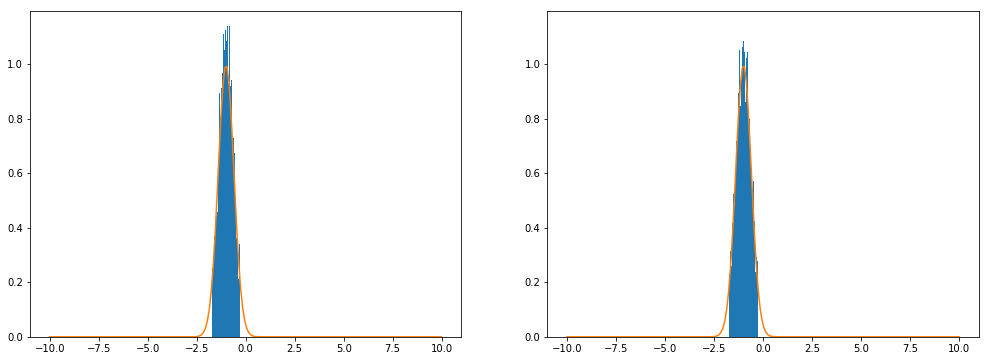

In [107]:
accepted_samps = samps.numpy()[accepted.numpy()]
accepted_decoded_samps = decoded_sample.numpy()[accepted.numpy()]

print("{:.2f}% of samples accepted".format(100 * len(accepted_samps) / len(samps)))

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.hist(accepted_samps, normed=True, bins=100)
plot_points = np.linspace(-10., 10., 200)
plt.plot(plot_points, tfd.Normal(loc=-1., scale=0.4).prob(plot_points))

plt.subplot(122)
plt.hist(accepted_decoded_samps, normed=True, bins=100)
plot_points = np.linspace(-10., 10., 200)
plt.plot(plot_points, tfd.Normal(loc=-1., scale=0.4).prob(plot_points))
plt.show()

In [33]:
print(samps.numpy()[accepted.numpy()])
print(accepted.numpy())
print(samps.numpy())

[1.5009458 2.14323   2.3730333 1.1985261 1.3671659]
[ True  True  True  True  True]
[1.5009458 2.14323   2.3730333 1.1985261 1.3671659]


In [67]:
np.all(accepted)

False

In [51]:
x = tf.convert_to_tensor(np.arange(16.).reshape((4, 4)))
y = tf.convert_to_tensor(np.arange(4.))
print(x)
print(y)

print(y * x)

print(y < x * y)

tf.Tensor(
[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]], shape=(4, 4), dtype=float64)
tf.Tensor([0. 1. 2. 3.], shape=(4,), dtype=float64)
tf.Tensor(
[[ 0.  1.  4.  9.]
 [ 0.  5. 12. 21.]
 [ 0.  9. 20. 33.]
 [ 0. 13. 28. 45.]], shape=(4, 4), dtype=float64)
tf.Tensor(
[[False False  True  True]
 [False  True  True  True]
 [False  True  True  True]
 [False  True  True  True]], shape=(4, 4), dtype=bool)


In [416]:
x_ = np.arange(16.).reshape((4, 4))
y_ = np.repeat(np.arange(4.)[None, :], 4, axis=0)

print(x_)
print(y_)
y_ < x_

[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]
[[0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]]


array([[False, False, False, False],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

References:

[1] Communication Cost of Correlation

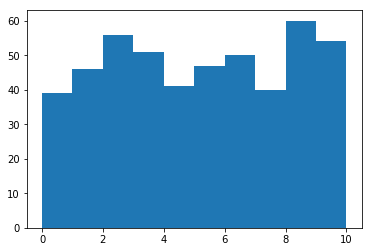

In [97]:
plt.hist(np.random.uniform(size=1000)*20, range=[0, 10])
plt.show()

In [98]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*. The return value is a
    tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
    [*patches0*, *patches1*,...]) if the input contains multiple
    data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported at present.
    
    Parameters
    ----------
    x : (n,) array or sequence of (n,) arrays
        Input values, this takes either a single array or a sequence of
        